# Hopf Syllables

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product
from functools import partial
from copy import copy

from dynamical_systems import Hopf_polar, Hopf_cartesian, airflow
from numerical_syllables import *
from aux_functions_manual import *

We consider the following system of equations (in polar and cartesian coordinates, respectively)
$$
\begin{cases}
\dot{r} \propto (\mu - r^2)r, \\
\dot{\theta} \propto \omega
\end{cases}
\qquad
\begin{cases}
\dot{x} \propto (\mu - x^2 - y^2) x - \omega y, \\
\dot{y} \propto (\mu - x^2 - y^2) y + \omega x
\end{cases}
$$

The bifurcation (from having a stable spiral close to the origin to a limit cycle) occurs when $\mu$ goes from negative to positive.


## Integration parameters

In [3]:
t0 = 0                  # Initial trajectory time
tf = 10                  # Final trajectory time 

# Use subsample=1 or 8 for testing (fast, low resolution), and 40 for high resolution.
# subsample = 1
# subsample = 8
subsample = 40

step = 1/(subsample * 44150.0)      # timestep

save = True if subsample == 40 else False

In [4]:
trange = np.arange(t0,tf,step)

## Equation parameters

In [5]:
w = 4.2             # CHANGE THIS TO MOVE THE SPECTRUM
y0 = (0.001,0)

type = "slow"
# type = "fast"

convolution = True # If true, multiply the parameter times the solution

In [6]:
def mu_function(t, height=2*1e6/6, lambda1=3, lambda2=3, T1=7, T2=3):
    
    return height * airflow(t, lambda1, lambda2, T1, T2) - 1 

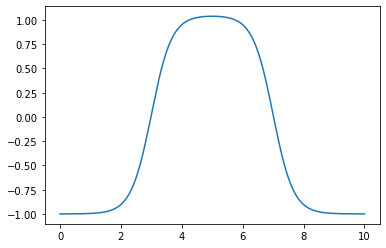

In [7]:
plt.plot(trange,[mu_function(t) for t in trange])

## Solution and plots

In [8]:
sol = RK45_Hopf(partial(Hopf_polar, prop=3000), y0, t0, tf, step, w, mu_function)

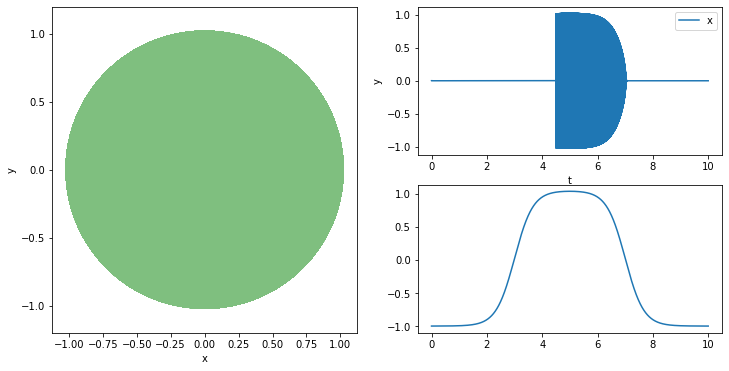

In [9]:
fig = plt.figure(figsize=(12, 6))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(2,2,2)
ax2 = plt.subplot(2,2,4)
ax = [ax0, ax1, ax2]

ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.axis('equal')

ax1.set_xlabel('t')
ax1.set_ylabel('y')
#ax1.set_ylabel('x,y')

ax0.plot(sol.y[0] * np.cos(sol.y[1]), sol.y[0] * np.sin(sol.y[1]), alpha=0.5, color="green")
ax1.plot(sol.t, sol.y[0] * np.cos(sol.y[1]), label="x")

#ax0.plot(sol.y[0], sol.y[1], alpha=0.5, color="green")
#ax1.plot(sol.t, sol.y[0], label="x")
#ax1.plot(sol.t, sol.y[1], label="y")

ax2.plot(sol.t, [mu_function(t) for t in sol.t])

ax1.legend()

In [10]:
tsol = sol.t[0::subsample]
rhosol = sol.y[0][0::subsample]
phisol = sol.y[1][0::subsample]
xsol = rhosol * np.cos(phisol)
ysol = rhosol * np.sin(phisol)

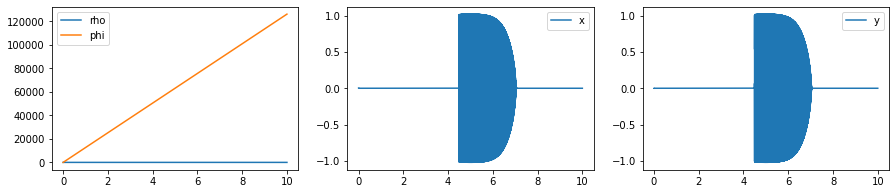

In [11]:
fig = plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(tsol, rhosol, label="rho")
plt.plot(tsol, phisol, label="phi")
plt.legend()
plt.subplot(1,3,2)
plt.plot(tsol, xsol, label="x")
plt.legend()
plt.subplot(1,3,3)
plt.plot(tsol, ysol, label="y")
plt.legend()

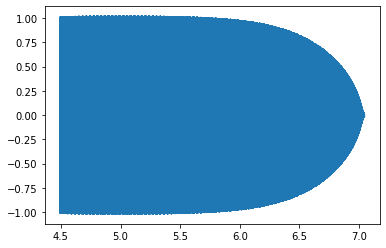

In [12]:
start = np.argmax(xsol > 0.01)
end = np.argmax(xsol[::-1] > 0.01)
window = [start-10,10-end]
xwindow = xsol[window[0]:window[1]]
twindow = tsol[window[0]:window[1]]
plt.plot(twindow, xwindow)

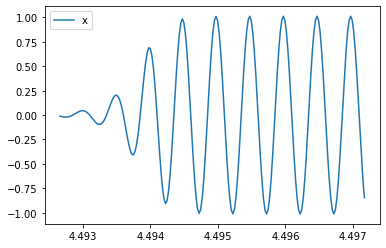

In [13]:
plt.plot(twindow[0:200], xwindow[0:200], label="x")
plt.legend()

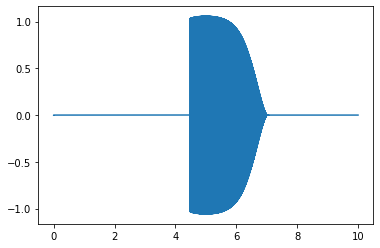

In [14]:
if convolution:
    gating = [mu_function(t) for t in tsol]
    xsol = np.multiply(gating, xsol)
    plt.plot(tsol, xsol)

In [15]:
if save:
    print("Saving solution")
    import pickle
    with open("Output/Hopf_xsol.pkl", 'wb') as f:
        pickle.dump({"tsol":tsol, "xsol":xsol}, f)
else:
    print("Solution not saved")

Saving solution


## Spectrum

In [16]:
from scipy.fft import fft, fftfreq, fftshift

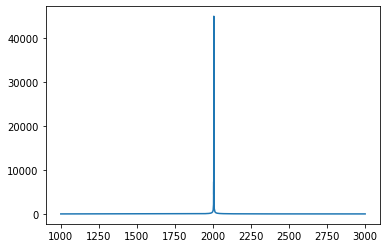

In [17]:
xf = fftfreq(len(xsol), step * subsample)[:len(xsol)//2]
yf = fft(xsol)
spectrum = np.abs(yf)[:len(xsol)//2]
plt.plot(xf[10000:30000], spectrum[10000:30000])

In [18]:
# fundamental freq
w / (step *subsample)

185430.00000000003

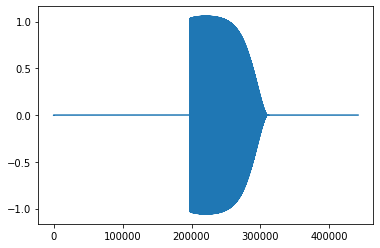

In [19]:
from scipy.fft import ifft
s = ifft(yf)
#s = ifft(yf[:100])
plt.plot(s.real)
#plt.plot(s.imag)


## Audio

In [19]:
from IPython.display import Audio
Audio(2*xsol, rate=int(1/(subsample*step)))

In [20]:
from scipy.io.wavfile import write

rate = int(1/(subsample*step))
scaled = np.int16(xsol / np.max(np.abs(xsol)) * 32767)
#write('Output/Hopf.wav', rate, scaled)